In [1]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import json
from datetime import datetime
import sys
import os
from collections import Counter
from scipy import stats
from scipy.stats import chi2_contingency, normaltest
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Adding src to path for imports
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'src'))

# Configuring display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')

# Setting plot style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("=== FEATURE ANALYSIS SETUP ===")
print(f"Python version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Analysis timestamp: {datetime.now()}")

=== FEATURE ANALYSIS SETUP ===
Python version: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Pandas version: 2.3.2
NumPy version: 2.2.6
Analysis timestamp: 2025-09-29 15:53:35.419503


In [2]:
# Cell 2: Loading Data and Configuration
# Project paths
PROJECT_ROOT = Path.cwd().parent.parent
DATA_RAW_PATH = PROJECT_ROOT / "data" / "raw"
DATA_PROCESSED_PATH = PROJECT_ROOT / "data" / "processed" 
RESULTS_PATH = PROJECT_ROOT / "results" / "data_exploration"

# Feature analysis results path
FEATURE_RESULTS_PATH = PROJECT_ROOT / "results" / "feature_analysis"
FEATURE_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Configuration
FEATURE_CONFIG = {
    'sample_size_large': 50000,    # For computationally expensive analysis
    'sample_size_medium': 10000,   # For detailed correlation analysis
    'sample_size_small': 5000,     # For visualization
    'correlation_threshold': 0.95, # For high correlation detection
    'mutual_info_threshold': 0.1,  # For feature importance
    'random_state': 42,
    'n_components_pca': 10,        # For PCA analysis
    'plot_style': 'plotly'         
}

print("=== DATA LOADING CONFIGURATION ===")
print(f"Sample sizes: Large={FEATURE_CONFIG['sample_size_large']}, "
      f"Medium={FEATURE_CONFIG['sample_size_medium']}, "
      f"Small={FEATURE_CONFIG['sample_size_small']}")
print(f"Analysis thresholds: Correlation={FEATURE_CONFIG['correlation_threshold']}, "
      f"Mutual Info={FEATURE_CONFIG['mutual_info_threshold']}")

=== DATA LOADING CONFIGURATION ===
Sample sizes: Large=50000, Medium=10000, Small=5000
Analysis thresholds: Correlation=0.95, Mutual Info=0.1


In [3]:
# Cell 3: Comprehensive Data Loading with Sampling
def load_datasets_with_sampling():
    """Loading datasets with intelligent sampling for analysis"""
    
    print("=== LOADING DATASETS ===")
    datasets = {}
    
    # Loading CICFlowMeter data (sample for analysis)
    print("Loading CICFlowMeter data...")
    cicflow_full = pd.read_csv(DATA_RAW_PATH / "CICFlowMeter_out.csv", low_memory=False)
    print(f"CICFlowMeter full size: {cicflow_full.shape}")
    
    # Sampling for analysis (stratified by label)
    if len(cicflow_full) > FEATURE_CONFIG['sample_size_large']:
        # Stratified sampling to maintain label distribution
        cicflow_sample = cicflow_full.groupby('Label', group_keys=False).apply(
            lambda x: x.sample(min(len(x), FEATURE_CONFIG['sample_size_large'] // 
                              cicflow_full['Label'].nunique()), 
                              random_state=FEATURE_CONFIG['random_state'])
        ).reset_index(drop=True)
    else:
        cicflow_sample = cicflow_full.copy()
    
    datasets['cicflow'] = {
        'full': cicflow_full,
        'sample': cicflow_sample,
        'shape_full': cicflow_full.shape,
        'shape_sample': cicflow_sample.shape
    }
    
    # Loading Data.csv
    print("Loading Data.csv...")
    data_df = pd.read_csv(DATA_RAW_PATH / "Data.csv", low_memory=False)
    datasets['data'] = {
        'full': data_df,
        'shape': data_df.shape
    }
    
    # Loading Labels.csv
    print("Loading Label.csv...")
    labels_df = pd.read_csv(DATA_RAW_PATH / "Label.csv")
    datasets['labels'] = {
        'full': labels_df,
        'shape': labels_df.shape
    }
    
    print(f"\nDataset Summary:")
    print(f"CICFlow: {datasets['cicflow']['shape_full']} (sampled: {datasets['cicflow']['shape_sample']})")
    print(f"Data: {datasets['data']['shape']}")
    print(f"Labels: {datasets['labels']['shape']}")
    
    return datasets

# Loading all datasets
datasets = load_datasets_with_sampling()

=== LOADING DATASETS ===
Loading CICFlowMeter data...
CICFlowMeter full size: (3540241, 84)
Loading Data.csv...
Loading Label.csv...

Dataset Summary:
CICFlow: (3540241, 84) (sampled: (32284, 84))
Data: (447915, 76)
Labels: (447915, 1)


In [4]:
# Cell 4: Label Analysis and Mapping
def analyze_labels():
    """Comprehensive analysis of labels and attack types"""
    
    print("=== LABEL ANALYSIS ===")
    
    # Analyzing CICFlowMeter labels (string labels)
    cicflow_labels = datasets['cicflow']['sample']['Label'].value_counts()
    print(f"\nCICFlowMeter Label Distribution:")
    for label, count in cicflow_labels.items():
        percentage = (count / len(datasets['cicflow']['sample'])) * 100
        print(f"  {label}: {count:,} ({percentage:.2f}%)")
    
    # Analyzing Data.csv labels (numerical)
    numerical_labels = datasets['labels']['full']['Label'].value_counts().sort_index()
    print(f"\nData.csv Numerical Label Distribution:")
    for label, count in numerical_labels.items():
        percentage = (count / len(datasets['labels']['full'])) * 100
        print(f"  {label}: {count:,} ({percentage:.2f}%)")
    
    # Creating label mapping by analyzing patterns
    print(f"\n=== LABEL MAPPING ANALYSIS ===")
    
    # Getting unique labels from both datasets
    string_labels = set(datasets['cicflow']['full']['Label'].unique())
    numerical_labels_set = set(datasets['labels']['full']['Label'].unique())
    
    print(f"String labels in CICFlow: {sorted(string_labels)}")
    print(f"Numerical labels in Data: {sorted(numerical_labels_set)}")
    
    # Attemptting to create mapping by sampling and comparing
    # Sampling CICFlow to match Data size and see if we can find patterns
    if len(datasets['cicflow']['full']) > len(datasets['data']['full']):
        print(f"\nAttempting to create label mapping...")
        
        # Using the first rows of each dataset to find potential mapping
        cicflow_subset = datasets['cicflow']['full'].head(len(datasets['data']['full']))
        data_subset = datasets['data']['full']
        labels_subset = datasets['labels']['full']
        
        # Checking if features match (they should based on our previous analysis)
        common_features = [col for col in data_subset.columns if col in cicflow_subset.columns]
        print(f"Common features for mapping: {len(common_features)}")
        
        # Creating a potential mapping based on order (if data is subset of cicflow)
        potential_mapping = {}
        cicflow_label_sample = cicflow_subset['Label'].head(1000)
        numerical_label_sample = labels_subset['Label'].head(1000)
        
        # Grouping by numerical label and see most common string label
        temp_df = pd.DataFrame({
            'string_label': cicflow_label_sample,
            'numerical_label': numerical_label_sample
        })
        
        mapping_analysis = temp_df.groupby('numerical_label')['string_label'].agg(['count', lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'Unknown']).reset_index()
        mapping_analysis.columns = ['numerical_label', 'count', 'most_common_string']
        
        print(f"\nPotential Label Mapping:")
        for _, row in mapping_analysis.iterrows():
            print(f"  {row['numerical_label']} → {row['most_common_string']} (confidence: {row['count']} samples)")
    
    # Class imbalance analysis
    print(f"\n=== CLASS IMBALANCE ANALYSIS ===")
    
    # Calculating imbalance metrics
    cicflow_imbalance = cicflow_labels.max() / cicflow_labels.min()
    numerical_imbalance = numerical_labels.max() / numerical_labels.min()
    
    print(f"CICFlow imbalance ratio: {cicflow_imbalance:.2f}")
    print(f"Numerical labels imbalance ratio: {numerical_imbalance:.2f}")
    
    # Recommendations for handling imbalance
    if cicflow_imbalance > 10 or numerical_imbalance > 10:
        print(f"⚠️  Significant class imbalance detected!")
        print(f"   Recommendations: SMOTE, class weights, or stratified sampling")
    else:
        print(f"✅ Moderate class imbalance - manageable with standard techniques")
    
    return {
        'cicflow_distribution': cicflow_labels,
        'numerical_distribution': numerical_labels,
        'imbalance_ratios': {
            'cicflow': cicflow_imbalance,
            'numerical': numerical_imbalance
        }
    }

# Performing label analysis
label_analysis = analyze_labels()

=== LABEL ANALYSIS ===

CICFlowMeter Label Distribution:
  Exploits: 5,000 (15.49%)
  Benign: 5,000 (15.49%)
  Fuzzers: 5,000 (15.49%)
  Reconnaissance: 5,000 (15.49%)
  Generic: 4,632 (14.35%)
  DoS: 4,467 (13.84%)
  Shellcode: 2,102 (6.51%)
  Backdoor: 452 (1.40%)
  Analysis: 385 (1.19%)
  Worms: 246 (0.76%)

Data.csv Numerical Label Distribution:
  0: 358,332 (80.00%)
  1: 385 (0.09%)
  2: 452 (0.10%)
  3: 4,467 (1.00%)
  4: 30,951 (6.91%)
  5: 29,613 (6.61%)
  6: 4,632 (1.03%)
  7: 16,735 (3.74%)
  8: 2,102 (0.47%)
  9: 246 (0.05%)

=== LABEL MAPPING ANALYSIS ===
String labels in CICFlow: ['Analysis', 'Backdoor', 'Benign', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms']
Numerical labels in Data: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]

Attempting to create label mapping...
Common features for mapping: 76

Potential Label Mapping:
  0 → Benign (confidence: 616 

In [5]:
# Cell 5: Feature Correlation Analysis
def analyze_feature_correlations():
    """Analyzing correlations between features for multi-modal separation"""
    
    print("=== FEATURE CORRELATION ANALYSIS ===")
    
    # Using Data.csv for correlation analysis (clean numerical features)
    data_sample = datasets['data']['full'].sample(
        n=min(FEATURE_CONFIG['sample_size_medium'], len(datasets['data']['full'])),
        random_state=FEATURE_CONFIG['random_state']
    )
    
    print(f"Analyzing correlations for {data_sample.shape[0]} samples, {data_sample.shape[1]} features")
    
    # Calculating correlation matrix with NaN handling
    correlation_matrix = data_sample.corr(method='pearson')
    
    # Handling NaN values (replace with 0)
    correlation_matrix = correlation_matrix.fillna(0)
    
    # Ensuring matrix is symmetric (fix floating point precision issues)
    correlation_matrix = (correlation_matrix + correlation_matrix.T) / 2
    
    # Finding highly correlated features
    high_corr_threshold = FEATURE_CONFIG['correlation_threshold']
    high_corr_pairs = []
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i+1, len(correlation_matrix.columns)):
            corr_value = abs(correlation_matrix.iloc[i, j])
            if corr_value > high_corr_threshold:
                high_corr_pairs.append({
                    'feature1': correlation_matrix.columns[i],
                    'feature2': correlation_matrix.columns[j],
                    'correlation': corr_value
                })
    
    print(f"\n=== HIGH CORRELATION PAIRS (>{high_corr_threshold}) ===")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', ascending=False)
    print(f"Found {len(high_corr_pairs)} highly correlated feature pairs:")
    for _, row in high_corr_df.head(10).iterrows():
        print(f"  {row['feature1']} ↔ {row['feature2']}: {row['correlation']:.3f}")
    
    # Feature clustering based on correlation
    try:
        from scipy.cluster.hierarchy import linkage, fcluster
        from scipy.spatial.distance import squareform
        
        # Converting correlation to distance matrix
        distance_matrix = 1 - abs(correlation_matrix)
        
        # Ensuring distance matrix is valid (symmetric, positive, with zero diagonal)
        np.fill_diagonal(distance_matrix.values, 0)  # Set diagonal to 0
        distance_matrix = (distance_matrix + distance_matrix.T) / 2  # Ensure symmetry
        
        # Checking if matrix is valid for clustering
        if not np.allclose(distance_matrix.values, distance_matrix.values.T):
            print("Warning: Distance matrix is not symmetric after correction")
            # Simple fallback clustering
            feature_clusters = {1: list(correlation_matrix.columns)}
        else:
            # Converting to condensed form for linkage
            condensed_distance = squareform(distance_matrix.values)
            
            # Performing hierarchical clustering
            linkage_matrix = linkage(condensed_distance, method='average')
            clusters = fcluster(linkage_matrix, t=0.3, criterion='distance')
            
            # Group features by clusters
            feature_clusters = {}
            for i, cluster_id in enumerate(clusters):
                if cluster_id not in feature_clusters:
                    feature_clusters[cluster_id] = []
                feature_clusters[cluster_id].append(correlation_matrix.columns[i])
        
        print(f"\n=== FEATURE CLUSTERING ===")
        print(f"Features grouped into {len(feature_clusters)} clusters:")
        for cluster_id, features in feature_clusters.items():
            if len(features) > 1:  # Only show clusters with multiple features
                print(f"  Cluster {cluster_id} ({len(features)} features): {features[:5]}{'...' if len(features) > 5 else ''}")
    
    except Exception as e:
        print(f"Warning: Clustering failed ({str(e)}), using simple grouping")
        # Fallback: group by high correlation
        feature_clusters = {1: list(correlation_matrix.columns)}
    
    return {
        'correlation_matrix': correlation_matrix,
        'high_corr_pairs': high_corr_df,
        'feature_clusters': feature_clusters,
        'data_sample': data_sample
    }

# Performing correlation analysis
correlation_analysis = analyze_feature_correlations()

=== FEATURE CORRELATION ANALYSIS ===
Analyzing correlations for 10000 samples, 76 features

=== HIGH CORRELATION PAIRS (>0.95) ===
Found 37 highly correlated feature pairs:
  Bwd Packet Length Mean ↔ Bwd Segment Size Avg: 1.000
  Fwd Packet Length Mean ↔ Fwd Segment Size Avg: 1.000
  Idle Mean ↔ Idle Min: 0.999
  Flow Packets/s ↔ Fwd Packets/s: 0.999
  Flow IAT Max ↔ Fwd IAT Max: 0.999
  Subflow Bwd Packets ↔ Subflow Bwd Bytes: 0.998
  Idle Mean ↔ Idle Max: 0.997
  Flow IAT Std ↔ Fwd IAT Std: 0.995
  Idle Max ↔ Idle Min: 0.994
  Flow IAT Mean ↔ Fwd IAT Mean: 0.994


In [6]:
# Cell 6: Feature Importance Analysis
def analyze_feature_importance():
    """Analyzing feature importance using multiple methods"""
    
    print("=== FEATURE IMPORTANCE ANALYSIS ===")
    
    # Preparing data for feature importance analysis
    # Using Data.csv + Labels.csv combination
    data_sample = datasets['data']['full'].sample(
        n=min(FEATURE_CONFIG['sample_size_medium'], len(datasets['data']['full'])),
        random_state=FEATURE_CONFIG['random_state']
    )
    labels_sample = datasets['labels']['full'].iloc[data_sample.index]
    
    X = data_sample.values
    y = labels_sample['Label'].values
    feature_names = data_sample.columns.tolist()
    
    print(f"Analyzing importance for {X.shape[1]} features with {len(np.unique(y))} classes")
    
    # Method 1: Mutual Information
    print("\n--- Mutual Information Analysis ---")
    mi_scores = mutual_info_classif(X, y, random_state=FEATURE_CONFIG['random_state'])
    mi_results = pd.DataFrame({
        'feature': feature_names,
        'mutual_info': mi_scores
    }).sort_values('mutual_info', ascending=False)
    
    print(f"Top 10 features by Mutual Information:")
    for _, row in mi_results.head(10).iterrows():
        print(f"  {row['feature']}: {row['mutual_info']:.4f}")
    
    # Method 2: F-statistic (ANOVA)
    print("\n--- ANOVA F-statistic Analysis ---")
    f_scores, p_values = f_classif(X, y)
    f_results = pd.DataFrame({
        'feature': feature_names,
        'f_score': f_scores,
        'p_value': p_values
    }).sort_values('f_score', ascending=False)
    
    print(f"Top 10 features by F-statistic:")
    for _, row in f_results.head(10).iterrows():
        print(f"  {row['feature']}: F={row['f_score']:.2f}, p={row['p_value']:.2e}")
    
    # Method 3: Variance analysis
    print("\n--- Feature Variance Analysis ---")
    feature_variances = data_sample.var().sort_values(ascending=False)
    print(f"Top 10 features by variance:")
    for feature, variance in feature_variances.head(10).items():
        print(f"  {feature}: {variance:.2e}")
    
    # Combined importance score
    print("\n--- Combined Importance Ranking ---")
    
    # Normalizing scores to 0-1 range
    mi_normalized = (mi_results['mutual_info'] - mi_results['mutual_info'].min()) / (mi_results['mutual_info'].max() - mi_results['mutual_info'].min())
    f_normalized = (f_results['f_score'] - f_results['f_score'].min()) / (f_results['f_score'].max() - f_results['f_score'].min())
    var_normalized = (feature_variances - feature_variances.min()) / (feature_variances.max() - feature_variances.min())
    
    # Creating combined scoring
    combined_scores = []
    for feature in feature_names:
        mi_score = mi_normalized[mi_results['feature'] == feature].iloc[0]
        f_score = f_normalized[f_results['feature'] == feature].iloc[0]
        var_score = var_normalized[feature]
        
        # Weighted combination (you can adjust weights)
        combined_score = 0.5 * mi_score + 0.3 * f_score + 0.2 * var_score
        combined_scores.append({
            'feature': feature,
            'combined_score': combined_score,
            'mi_score': mi_score,
            'f_score': f_score,
            'var_score': var_score
        })
    
    combined_results = pd.DataFrame(combined_scores).sort_values('combined_score', ascending=False)
    
    print(f"Top 15 features by combined importance:")
    for _, row in combined_results.head(15).iterrows():
        print(f"  {row['feature']}: {row['combined_score']:.3f} "
              f"(MI:{row['mi_score']:.2f}, F:{row['f_score']:.2f}, Var:{row['var_score']:.2f})")
    
    return {
        'mutual_info': mi_results,
        'f_statistics': f_results,
        'variances': feature_variances,
        'combined_importance': combined_results,
        'feature_names': feature_names
    }

# Performing feature importance analysis
importance_analysis = analyze_feature_importance()

=== FEATURE IMPORTANCE ANALYSIS ===
Analyzing importance for 76 features with 10 classes

--- Mutual Information Analysis ---
Top 10 features by Mutual Information:
  Bwd Header Length: 0.4220
  Fwd Header Length: 0.3725
  Fwd Seg Size Min: 0.3695
  FWD Init Win Bytes: 0.3680
  Bwd Init Win Bytes: 0.3660
  Packet Length Max: 0.3486
  Bwd Packets/s: 0.3339
  Flow IAT Mean: 0.3222
  Flow Packets/s: 0.3157
  Total Fwd Packet: 0.3149

--- ANOVA F-statistic Analysis ---
Top 10 features by F-statistic:
  Fwd Seg Size Min: F=254.39, p=0.00e+00
  Bwd Packets/s: F=234.25, p=0.00e+00
  Fwd IAT Min: F=190.40, p=0.00e+00
  FIN Flag Count: F=181.41, p=3.30e-320
  Fwd Packets/s: F=105.28, p=3.93e-189
  Flow Packets/s: F=98.20, p=1.46e-176
  Fwd Packet Length Mean: F=70.04, p=7.27e-126
  Fwd Segment Size Avg: F=70.04, p=7.27e-126
  Flow IAT Min: F=64.69, p=4.05e-116
  Average Packet Size: F=63.16, p=2.47e-113

--- Feature Variance Analysis ---
Top 10 features by variance:
  Flow Bytes/s: 7.40e+14
  B

In [7]:
# Cell 7: Multi-Modal Feature Separation Strategy
def design_multimodal_features():
    """Designing feature separation strategy for HybridFormer branches"""
    
    print("=== MULTI-MODAL FEATURE SEPARATION ===")
    
    # Getting feature names from Data.csv (76 features)
    all_features = datasets['data']['full'].columns.tolist()
    
    # Defining feature categories based on network flow analysis
    feature_categories = {
        'temporal_features': [],      # For Transformer branch (sequential patterns)
        'statistical_features': [],   # For CNN branch (local patterns)
        'behavioral_features': [],    # For Graph branch (relationships)
        'protocol_features': [],      # Network protocol specific
        'size_features': [],          # Packet/flow size related
        'timing_features': []         # Inter-arrival times, durations
    }
    
    # Categorizing features based on names and semantics
    for feature in all_features:
        feature_lower = feature.lower()
        
        # Temporal/timing features (good for Transformer)
        if any(term in feature_lower for term in ['iat', 'duration', 'time', 'mean', 'std']):
            feature_categories['temporal_features'].append(feature)
        
        # Statistical features (good for CNN - local patterns)
        elif any(term in feature_lower for term in ['max', 'min', 'variance', 'length', 'size']):
            feature_categories['statistical_features'].append(feature)
        
        # Behavioral features (good for Graph - connection patterns)
        elif any(term in feature_lower for term in ['flag', 'ratio', 'bulk', 'init', 'active', 'idle']):
            feature_categories['behavioral_features'].append(feature)
        
        # Protocol specific features
        elif any(term in feature_lower for term in ['header', 'segment', 'win', 'bytes']):
            feature_categories['protocol_features'].append(feature)
        
        # Size related features
        elif any(term in feature_lower for term in ['packet', 'fwd', 'bwd']):
            feature_categories['size_features'].append(feature)
        
        # Default to timing if not categorized
        else:
            feature_categories['timing_features'].append(feature)
    
    print("Feature categorization:")
    for category, features in feature_categories.items():
        print(f"  {category}: {len(features)} features")
        if features:
            print(f"    Sample: {features[:3]}{'...' if len(features) > 3 else ''}")
    
    # Designing branch-specific feature sets
    branch_features = {
        'cnn_branch': (
            feature_categories['statistical_features'] + 
            feature_categories['size_features']
        ),
        'transformer_branch': (
            feature_categories['temporal_features'] + 
            feature_categories['timing_features']
        ),
        'graph_branch': (
            feature_categories['behavioral_features'] + 
            feature_categories['protocol_features']
        )
    }
    
    print(f"\n=== BRANCH FEATURE ALLOCATION ===")
    total_allocated = 0
    for branch, features in branch_features.items():
        print(f"{branch}: {len(features)} features")
        total_allocated += len(features)
        if features:
            print(f"  Sample features: {features[:5]}{'...' if len(features) > 5 else ''}")
    
    print(f"\nTotal features allocated: {total_allocated}/{len(all_features)}")
    
    # Handling overlaps and ensuring all features are used
    all_branch_features = set()
    for features in branch_features.values():
        all_branch_features.update(features)
    
    unallocated_features = set(all_features) - all_branch_features
    if unallocated_features:
        print(f"Unallocated features ({len(unallocated_features)}): {list(unallocated_features)[:5]}{'...' if len(unallocated_features) > 5 else ''}")
        # Addding unallocated to the branch with fewest features
        min_branch = min(branch_features.keys(), key=lambda x: len(branch_features[x]))
        branch_features[min_branch].extend(list(unallocated_features))
        print(f"Added to {min_branch}")
    
    # Using feature importance to refine selections
    print(f"\n=== IMPORTANCE-BASED REFINEMENT ===")
    top_features = importance_analysis['combined_importance'].head(50)['feature'].tolist()
    
    refined_branch_features = {}
    for branch, features in branch_features.items():
        # Keeping important features and add some based on importance
        important_in_branch = [f for f in features if f in top_features]
        
        # If branch has too few important features, add more from top features
        if len(important_in_branch) < 15:  # Minimum features per branch
            remaining_top = [f for f in top_features if f not in important_in_branch]
            additional_needed = 15 - len(important_in_branch)
            important_in_branch.extend(remaining_top[:additional_needed])
        
        refined_branch_features[branch] = important_in_branch[:25]  # Max 25 features per branch
    
    print("Refined feature allocation (importance-based):")
    for branch, features in refined_branch_features.items():
        print(f"  {branch}: {len(features)} features")
    
    return {
        'feature_categories': feature_categories,
        'branch_features': branch_features,
        'refined_branch_features': refined_branch_features,
        'all_features': all_features
    }

# Designing multi-modal feature separation
multimodal_design = design_multimodal_features()

=== MULTI-MODAL FEATURE SEPARATION ===
Feature categorization:
  temporal_features: 25 features
    Sample: ['Flow Duration', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']...
  statistical_features: 19 features
    Sample: ['Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max']...
  behavioral_features: 21 features
    Sample: ['Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags']...
  protocol_features: 3 features
    Sample: ['Flow Bytes/s', 'Subflow Fwd Bytes', 'Subflow Bwd Bytes']
  size_features: 8 features
    Sample: ['Total Fwd Packet', 'Total Bwd packets', 'Flow Packets/s']...
  timing_features: 0 features

=== BRANCH FEATURE ALLOCATION ===
cnn_branch: 27 features
  Sample features: ['Total Length of Fwd Packet', 'Total Length of Bwd Packet', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Bwd Packet Length Max']...
transformer_branch: 25 features
  Sample features: ['Flow Duration', 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Pac

In [8]:
# Cell 8: Graph Construction Feature Analysis
def analyze_graph_construction_features():
    """Analyze features for graph construction in GraphVAE"""
    
    print("=== GRAPH CONSTRUCTION FEATURE ANALYSIS ===")
    
    # Sample data for graph analysis
    data_sample = datasets['data']['full'].sample(
        n=min(FEATURE_CONFIG['sample_size_small'], len(datasets['data']['full'])),
        random_state=FEATURE_CONFIG['random_state']
    )
    
    print(f"Analyzing {data_sample.shape[0]} samples for graph construction")
    
    # Identify features suitable for different graph construction strategies
    graph_features = {
        'node_features': [],      # Features that define node properties
        'edge_features': [],      # Features that can define edge weights
        'similarity_features': [], # Features for similarity-based edges
        'temporal_features': [],   # Features for temporal edges
        'connectivity_features': [] # Features indicating connections
    }
    
    all_features = data_sample.columns.tolist()
    
    # Categorize features for graph construction
    for feature in all_features:
        feature_lower = feature.lower()
        
        # Node features (intrinsic properties of flows)
        if any(term in feature_lower for term in ['duration', 'total', 'average', 'ratio']):
            graph_features['node_features'].append(feature)
        
        # Edge features (relationship indicators)
        elif any(term in feature_lower for term in ['iat', 'flow', 'packet']):
            graph_features['edge_features'].append(feature)
        
        # Similarity features (for correlation-based edges)
        elif any(term in feature_lower for term in ['length', 'size', 'bytes']):
            graph_features['similarity_features'].append(feature)
        
        # Temporal features (for time-based edges)
        elif any(term in feature_lower for term in ['time', 'mean', 'std', 'max', 'min']):
            graph_features['temporal_features'].append(feature)
        
        # Connectivity features (protocol, flags, etc.)
        elif any(term in feature_lower for term in ['flag', 'header', 'init', 'win']):
            graph_features['connectivity_features'].append(feature)
    
    print("Graph construction feature categories:")
    for category, features in graph_features.items():
        print(f"  {category}: {len(features)} features")
        if features:
            print(f"    Sample: {features[:3]}{'...' if len(features) > 3 else ''}")
    
    # Analyze feature distributions for graph construction
    print(f"\n=== FEATURE DISTRIBUTION ANALYSIS FOR GRAPHS ===")
    
    # Calculate feature statistics relevant for graph construction
    feature_stats = {}
    for feature in all_features:
        values = data_sample[feature]
        feature_stats[feature] = {
            'mean': values.mean(),
            'std': values.std(),
            'min': values.min(),
            'max': values.max(),
            'unique_values': values.nunique(),
            'zero_ratio': (values == 0).sum() / len(values),
            'outlier_ratio': len(values[(values < values.quantile(0.01)) | 
                                      (values > values.quantile(0.99))]) / len(values)
        }
    
    # Identify best features for different graph construction methods
    print(f"\n--- Feature Suitability Analysis ---")
    
    # Features with good variance (suitable for similarity-based edges)
    high_variance_features = sorted(
        [(f, stats['std']) for f, stats in feature_stats.items()],
        key=lambda x: x[1], reverse=True
    )[:10]
    
    print("Top 10 features by variance (good for similarity graphs):")
    for feature, variance in high_variance_features:
        print(f"  {feature}: std={variance:.2f}")
    
    # Features with good distribution (not too many zeros)
    well_distributed_features = [
        f for f, stats in feature_stats.items() 
        if stats['zero_ratio'] < 0.8 and stats['unique_values'] > 100
    ]
    
    print(f"\nWell-distributed features ({len(well_distributed_features)}): suitable for correlation graphs")
    if well_distributed_features:
        print(f"  Sample: {well_distributed_features[:5]}{'...' if len(well_distributed_features) > 5 else ''}")
    
    # Graph construction strategies
    graph_strategies = {
        'correlation_based': {
            'description': 'Edges based on feature correlation',
            'suitable_features': well_distributed_features[:20],
            'threshold': 0.3,
            'method': 'pearson_correlation'
        },
        'knn_based': {
            'description': 'K-nearest neighbors in feature space',
            'suitable_features': [f[0] for f in high_variance_features],
            'k': 5,
            'method': 'euclidean_distance'
        },
        'temporal_based': {
            'description': 'Edges based on temporal proximity',
            'suitable_features': graph_features['temporal_features'][:10],
            'window_size': 60,  # seconds
            'method': 'time_window'
        }
    }
    
    print(f"\n=== RECOMMENDED GRAPH CONSTRUCTION STRATEGIES ===")
    for strategy, config in graph_strategies.items():
        print(f"{strategy}:")
        print(f"  Description: {config['description']}")
        print(f"  Features: {len(config['suitable_features'])} selected")
        print(f"  Method: {config['method']}")
    
    return {
        'graph_features': graph_features,
        'feature_stats': feature_stats,
        'graph_strategies': graph_strategies,
        'high_variance_features': high_variance_features,
        'well_distributed_features': well_distributed_features
    }

# Analyze graph construction features
graph_analysis = analyze_graph_construction_features()

=== GRAPH CONSTRUCTION FEATURE ANALYSIS ===
Analyzing 5000 samples for graph construction
Graph construction feature categories:
  node_features: 9 features
    Sample: ['Flow Duration', 'Total Fwd Packet', 'Total Bwd packets']...
  edge_features: 35 features
    Sample: ['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean']...
  similarity_features: 9 features
    Sample: ['Fwd Header Length', 'Bwd Header Length', 'Fwd Segment Size Avg']...
  temporal_features: 8 features
    Sample: ['Active Mean', 'Active Std', 'Active Max']...
  connectivity_features: 12 features
    Sample: ['Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags']...

=== FEATURE DISTRIBUTION ANALYSIS FOR GRAPHS ===

--- Feature Suitability Analysis ---
Top 10 features by variance (good for similarity graphs):
  Flow Bytes/s: std=19027878.92
  Bwd Bulk Rate Avg: std=12982570.30
  Flow Duration: std=3687540.88
  Fwd IAT Total: std=3612281.78
  Bwd IAT Total: std=2735545.47
  Fwd IAT Max: std=2638298

In [9]:
# Cell 9: Feature Engineering Recommendations
def generate_feature_engineering_recommendations():
    """Generating recommendations for feature engineering and preprocessing"""
    
    print("=== FEATURE ENGINEERING RECOMMENDATIONS ===")
    
    recommendations = {
        'preprocessing': [],
        'feature_creation': [],
        'dimensionality_reduction': [],
        'multimodal_fusion': [],
        'graph_construction': []
    }
    
    # Preprocessing recommendations
    print("--- Preprocessing Recommendations ---")
    
    # Checking for normalization needs
    data_sample = correlation_analysis['data_sample']
    feature_ranges = {}
    for col in data_sample.columns:
        feature_ranges[col] = {
            'min': data_sample[col].min(),
            'max': data_sample[col].max(),
            'range': data_sample[col].max() - data_sample[col].min()
        }
    
    # Features with very different scales
    large_range_features = [f for f, r in feature_ranges.items() if r['range'] > 1e6]
    small_range_features = [f for f, r in feature_ranges.items() if r['range'] < 1]
    
    if large_range_features or small_range_features:
        recommendations['preprocessing'].append(
            f"NORMALIZATION NEEDED: {len(large_range_features)} features with large ranges, "
            f"{len(small_range_features)} with small ranges"
        )
        print(f"Normalization required for {len(large_range_features + small_range_features)} features")
    
    # High correlation removal
    high_corr_count = len(correlation_analysis['high_corr_pairs'])
    if high_corr_count > 10:
        recommendations['preprocessing'].append(
            f"CORRELATION FILTERING: Remove {high_corr_count} highly correlated feature pairs"
        )
        print(f"Remove {high_corr_count} highly correlated features")
    
    # Zero variance check
    zero_var_features = [col for col in data_sample.columns if data_sample[col].std() < 1e-6]
    if zero_var_features:
        recommendations['preprocessing'].append(
            f"ZERO VARIANCE: Remove {len(zero_var_features)} features with zero/near-zero variance"
        )
        print(f"Remove {len(zero_var_features)} zero-variance features")
    
    # Feature creation recommendations
    print("\n--- Feature Creation Recommendations ---")
    
    # Ratio features
    ratio_candidates = [f for f in data_sample.columns if 'fwd' in f.lower()]
    bwd_candidates = [f for f in data_sample.columns if 'bwd' in f.lower()]
    
    if ratio_candidates and bwd_candidates:
        recommendations['feature_creation'].append(
            f"CREATE RATIO FEATURES: {len(ratio_candidates)} fwd/{len(bwd_candidates)} bwd feature pairs"
        )
        print(f"Create {len(ratio_candidates)} forward/backward ratio features")
    
    # Statistical aggregation features
    timing_features = [f for f in data_sample.columns if any(term in f.lower() for term in ['iat', 'time', 'duration'])]
    if len(timing_features) > 5:
        recommendations['feature_creation'].append(
            f"TEMPORAL AGGREGATION: Create rolling statistics from {len(timing_features)} timing features"
        )
        print(f"Create temporal aggregation features from {len(timing_features)} timing features")
    
    # Interaction features for important features
    top_features = importance_analysis['combined_importance'].head(10)['feature'].tolist()
    recommendations['feature_creation'].append(
        f"INTERACTION FEATURES: Create pairwise interactions from top {len(top_features)} important features"
    )
    print(f"Create interaction features from top {len(top_features)} features")
    
    # Polynomial features
    recommendations['feature_creation'].append(
        "POLYNOMIAL FEATURES: Create squared and cubed terms for top 5 features"
    )
    print(f"Create polynomial features for top features")
    
    # Dimensionality reduction recommendations
    print("\n--- Dimensionality Reduction Recommendations ---")
    
    total_features = len(data_sample.columns)
    if total_features > 50:
        recommendations['dimensionality_reduction'].append(
            f"PCA REDUCTION: Reduce from {total_features} to ~{total_features//2} features while retaining 95% variance"
        )
        print(f"Apply PCA to reduce from {total_features} to ~{total_features//2} features")
    
    # Feature selection based on importance
    low_importance_features = importance_analysis['combined_importance'].tail(20)['feature'].tolist()
    recommendations['dimensionality_reduction'].append(
        f"IMPORTANCE FILTERING: Remove {len(low_importance_features)} low-importance features"
    )
    print(f"Remove {len(low_importance_features)} low-importance features")
    
    # Variance-based filtering
    low_variance_threshold = data_sample.var().quantile(0.1)
    low_var_features = [col for col in data_sample.columns if data_sample[col].var() < low_variance_threshold]
    if len(low_var_features) > 5:
        recommendations['dimensionality_reduction'].append(
            f"VARIANCE FILTERING: Remove {len(low_var_features)} low-variance features"
        )
        print(f"Remove {len(low_var_features)} low-variance features")
    
    # Multi-modal fusion recommendations
    print("\n--- Multi-Modal Fusion Recommendations ---")
    
    branch_features = multimodal_design['refined_branch_features']
    recommendations['multimodal_fusion'].append(
        f"BRANCH OPTIMIZATION: CNN({len(branch_features['cnn_branch'])}), "
        f"Transformer({len(branch_features['transformer_branch'])}), "
        f"Graph({len(branch_features['graph_branch'])}) features"
    )
    print(f"Optimize branch feature allocation: CNN({len(branch_features['cnn_branch'])}), "
          f"Transformer({len(branch_features['transformer_branch'])}), Graph({len(branch_features['graph_branch'])})")
    
    # Cross-attention recommendations
    recommendations['multimodal_fusion'].append(
        "CROSS-ATTENTION: Implement attention between CNN-Transformer, Transformer-Graph, Graph-CNN pairs"
    )
    print(f"Implement cross-attention between all branch pairs")
    
    # Feature embedding recommendations
    recommendations['multimodal_fusion'].append(
        "FEATURE EMBEDDING: Use learnable embeddings for categorical features and feature importance weighting"
    )
    print(f"Implement learnable feature embeddings")
    
    # Branch balancing
    recommendations['multimodal_fusion'].append(
        "BRANCH BALANCING: Ensure similar feature count distribution across branches"
    )
    print(f"Balance feature distribution across branches")
    
    # Graph construction recommendations
    print("\n--- Graph Construction Recommendations ---")
    
    graph_strategies = graph_analysis['graph_strategies']
    for strategy, config in graph_strategies.items():
        recommendations['graph_construction'].append(
            f"{strategy.upper()}: Use {len(config['suitable_features'])} features with {config['method']}"
        )
        print(f"{strategy}: {len(config['suitable_features'])} features with {config['method']}")
    
    # Multi-level graph recommendation
    recommendations['graph_construction'].append(
        "HIERARCHICAL GRAPHS: Create flow-level and packet-level graphs with cross-level edges"
    )
    print(f"Implement hierarchical graph construction")
    
    # Dynamic graph recommendation
    recommendations['graph_construction'].append(
        "DYNAMIC GRAPHS: Update graph structure based on temporal patterns"
    )
    print(f"Implement dynamic graph updates")
    
    # Edge feature engineering
    edge_candidates = [f for f in data_sample.columns if any(term in f.lower() for term in ['iat', 'flow', 'packet'])]
    recommendations['graph_construction'].append(
        f"EDGE FEATURES: Use {len(edge_candidates)} features for edge weight calculation"
    )
    print(f"Use {len(edge_candidates)} features for edge weights")
    
    # Summary statistics
    print(f"\n=== RECOMMENDATION SUMMARY ===")
    print(f"Total recommendations: {sum(len(v) for v in recommendations.values())}")
    for category, recs in recommendations.items():
        print(f"  {category}: {len(recs)} recommendations")
    
    return recommendations

# Generating comprehensive recommendations
engineering_recommendations = generate_feature_engineering_recommendations()

=== FEATURE ENGINEERING RECOMMENDATIONS ===
--- Preprocessing Recommendations ---
Normalization required for 38 features
Remove 37 highly correlated features
Remove 10 zero-variance features

--- Feature Creation Recommendations ---
Create 24 forward/backward ratio features
Create temporal aggregation features from 15 timing features
Create interaction features from top 10 features
Create polynomial features for top features

--- Dimensionality Reduction Recommendations ---
Apply PCA to reduce from 76 to ~38 features
Remove 20 low-importance features

--- Multi-Modal Fusion Recommendations ---
Optimize branch feature allocation: CNN(20), Transformer(20), Graph(15)
Implement cross-attention between all branch pairs
Implement learnable feature embeddings
Balance feature distribution across branches

--- Graph Construction Recommendations ---
correlation_based: 20 features with pearson_correlation
knn_based: 10 features with euclidean_distance
temporal_based: 8 features with time_window
I

=== CREATING ADVANCED VISUALIZATIONS ===
Creating feature importance visualization...


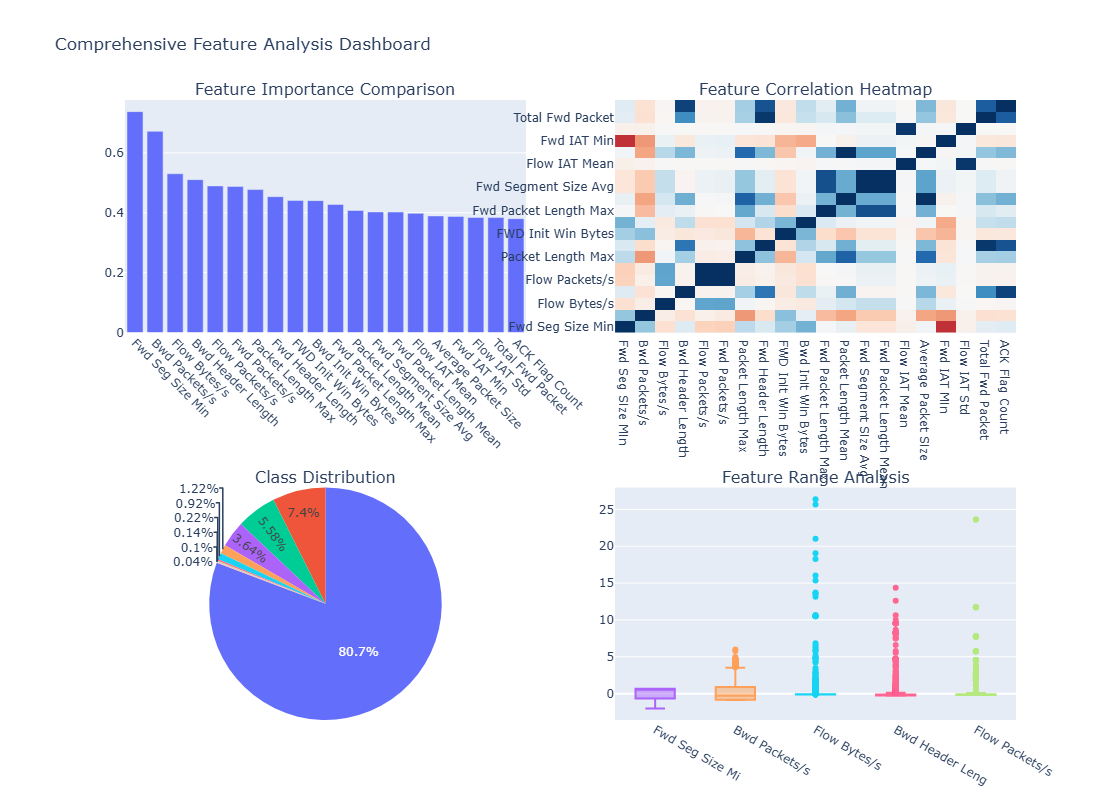

Creating branch feature distribution...


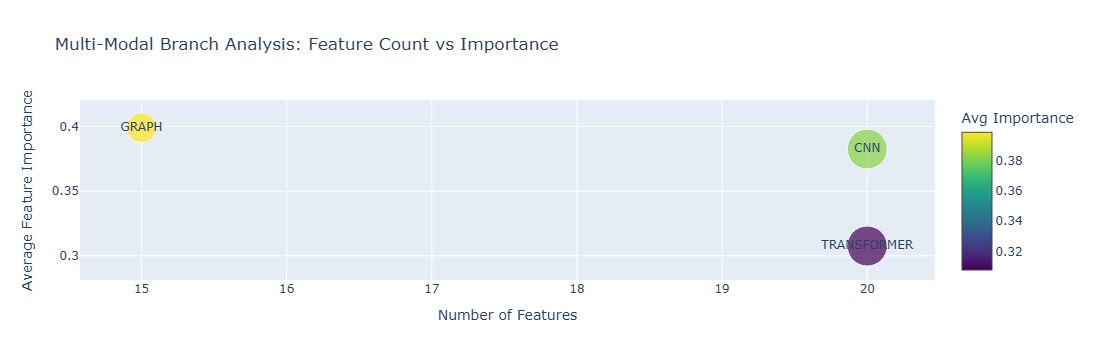

Creating graph construction analysis...


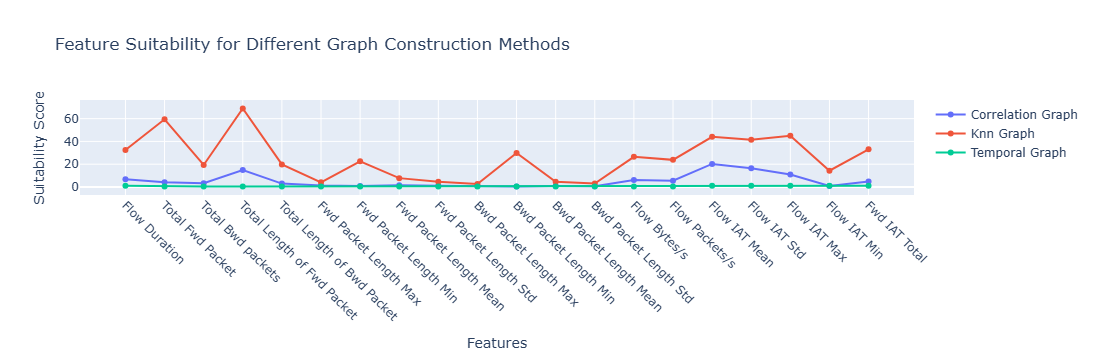

Advanced visualizations created successfully!


In [10]:
# Cell 10: Advanced Feature Analysis and Visualization
def create_advanced_visualizations():
    """Creating advanced visualizations for feature analysis"""
    
    print("=== CREATING ADVANCED VISUALIZATIONS ===")
    
    # Sample data for visualization
    data_sample = datasets['data']['full'].sample(
        n=FEATURE_CONFIG['sample_size_small'], 
        random_state=FEATURE_CONFIG['random_state']
    )
    labels_sample = datasets['labels']['full'].iloc[data_sample.index]
    
    # 1. Feature Importance Heatmap
    print("Creating feature importance visualization...")
    
    top_features = importance_analysis['combined_importance'].head(20)
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Feature Importance Comparison', 'Feature Correlation Heatmap', 
                       'Class Distribution', 'Feature Range Analysis'),
        specs=[[{"type": "bar"}, {"type": "heatmap"}],
               [{"type": "pie"}, {"type": "box"}]]
    )
    
    # Feature importance comparison
    fig.add_trace(
        go.Bar(x=top_features['feature'], y=top_features['combined_score'],
               name='Combined Score', showlegend=False),
        row=1, col=1
    )
    
    # Correlation heatmap for top features
    top_feature_names = top_features['feature'].tolist()
    corr_subset = correlation_analysis['correlation_matrix'].loc[top_feature_names, top_feature_names]
    
    fig.add_trace(
        go.Heatmap(z=corr_subset.values, x=corr_subset.columns, y=corr_subset.index,
                   colorscale='RdBu', zmid=0, showscale=False),
        row=1, col=2
    )
    
    # Class distribution
    class_counts = labels_sample['Label'].value_counts()
    fig.add_trace(
        go.Pie(labels=class_counts.index, values=class_counts.values, showlegend=False),
        row=2, col=1
    )
    
    # Feature range analysis (box plot for top 10 features)
    top_10_features = top_features.head(10)['feature'].tolist()
    
    # Normalize features for comparison
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    normalized_data = scaler.fit_transform(data_sample[top_10_features])
    normalized_df = pd.DataFrame(normalized_data, columns=top_10_features)
    
    for i, feature in enumerate(top_10_features[:5]):  # Show only 5 for clarity
        fig.add_trace(
            go.Box(y=normalized_df[feature], name=feature[:15], showlegend=False),
            row=2, col=2
        )
    
    fig.update_layout(height=800, title_text="Comprehensive Feature Analysis Dashboard")
    fig.update_xaxes(tickangle=45, row=1, col=1)
    fig.show()
    
    # 2. Branch Feature Distribution
    print("Creating branch feature distribution...")
    
    branch_features = multimodal_design['refined_branch_features']
    branch_importance = {}
    
    for branch, features in branch_features.items():
        branch_scores = []
        for feature in features:
            score_row = importance_analysis['combined_importance'][
                importance_analysis['combined_importance']['feature'] == feature
            ]
            if not score_row.empty:
                branch_scores.append(score_row['combined_score'].iloc[0])
        branch_importance[branch] = np.mean(branch_scores) if branch_scores else 0
    
    # Branch comparison plot
    fig_branch = go.Figure()
    
    branches = list(branch_importance.keys())
    importance_scores = list(branch_importance.values())
    feature_counts = [len(branch_features[branch]) for branch in branches]
    
    fig_branch.add_trace(
        go.Scatter(x=feature_counts, y=importance_scores,
                  mode='markers+text',
                  text=[b.replace('_branch', '').upper() for b in branches],
                  textposition="middle center",
                  marker=dict(size=[c*2 for c in feature_counts], 
                            color=importance_scores,
                            colorscale='Viridis',
                            showscale=True,
                            colorbar=dict(title="Avg Importance")),
                  name='Branches')
    )
    
    fig_branch.update_layout(
        title='Multi-Modal Branch Analysis: Feature Count vs Importance',
        xaxis_title='Number of Features',
        yaxis_title='Average Feature Importance',
        showlegend=False
    )
    fig_branch.show()
    
    # 3. Graph Construction Analysis
    print("Creating graph construction analysis...")
    
    # Analyzing feature suitability for different graph types
    graph_suitability = {
        'correlation': [],
        'knn': [],
        'temporal': []
    }
    
    for feature in data_sample.columns[:20]:  # Analyze top 20 features
        values = data_sample[feature]
        
        # Correlation suitability (good variance, not too many zeros)
        correlation_score = (values.std() / (values.mean() + 1e-8)) * (1 - (values == 0).sum() / len(values))
        graph_suitability['correlation'].append(correlation_score)
        
        # KNN suitability (good distribution, wide range)
        knn_score = (values.max() - values.min()) / (values.std() + 1e-8)
        graph_suitability['knn'].append(knn_score)
        
        # Temporal suitability (for timing features)
        temporal_score = 1.0 if any(term in feature.lower() for term in ['time', 'iat', 'duration']) else 0.5
        graph_suitability['temporal'].append(temporal_score)
    
    # Graph suitability comparison
    fig_graph = go.Figure()
    
    features_subset = data_sample.columns[:20].tolist()
    
    for graph_type, scores in graph_suitability.items():
        fig_graph.add_trace(
            go.Scatter(x=features_subset, y=scores,
                      mode='lines+markers',
                      name=f'{graph_type.capitalize()} Graph',
                      line=dict(width=2))
        )
    
    fig_graph.update_layout(
        title='Feature Suitability for Different Graph Construction Methods',
        xaxis_title='Features',
        yaxis_title='Suitability Score',
        xaxis=dict(tickangle=45)
    )
    fig_graph.show()
    
    print("Advanced visualizations created successfully!")
    
    return {
        'branch_importance': branch_importance,
        'graph_suitability': graph_suitability
    }

# Creating advanced visualizations
visualization_results = create_advanced_visualizations()

In [11]:
# Cell 11: Feature Engineering Pipeline Design
def design_preprocessing_pipeline():
    """Designing the complete preprocessing pipeline"""
    
    print("=== PREPROCESSING PIPELINE DESIGN ===")
    
    pipeline_config = {
        'stage_1_cleaning': {
            'description': 'Data cleaning and basic preprocessing',
            'operations': [
                'handle_missing_values',
                'remove_duplicates', 
                'data_type_optimization',
                'outlier_detection'
            ]
        },
        'stage_2_feature_engineering': {
            'description': 'Feature creation and transformation',
            'operations': [
                'create_ratio_features',
                'create_interaction_features',
                'create_temporal_aggregations',
                'create_statistical_features'
            ]
        },
        'stage_3_normalization': {
            'description': 'Feature scaling and normalization',
            'operations': [
                'standard_scaling',
                'robust_scaling_for_outliers',
                'min_max_scaling_for_bounded_features'
            ]
        },
        'stage_4_selection': {
            'description': 'Feature selection and dimensionality reduction',
            'operations': [
                'correlation_filtering',
                'importance_based_selection',
                'variance_threshold_filtering',
                'pca_transformation'
            ]
        },
        'stage_5_multimodal_preparation': {
            'description': 'Prepare features for different model branches',
            'operations': [
                'branch_feature_allocation',
                'feature_embedding_preparation',
                'graph_construction_features'
            ]
        }
    }
    
    # Detailed pipeline implementation
    print("Pipeline stages:")
    for stage, config in pipeline_config.items():
        print(f"\n{stage.upper()}: {config['description']}")
        for i, operation in enumerate(config['operations'], 1):
            print(f"  {i}. {operation.replace('_', ' ').title()}")
    
    # Specific configurations for each stage
    detailed_config = {
        'cleaning': {
            'missing_value_threshold': 0.05,  # Remove features with >5% missing
            'outlier_method': 'iqr',          # IQR method for outlier detection
            'outlier_threshold': 3.0          # 3 IQR threshold
        },
        'feature_engineering': {
            'ratio_features': {
                'fwd_bwd_ratios': True,
                'packet_byte_ratios': True,
                'timing_ratios': True
            },
            'interaction_features': {
                'top_k_features': 10,
                'polynomial_degree': 2
            },
            'temporal_features': {
                'window_sizes': [5, 10, 20],
                'aggregations': ['mean', 'std', 'max', 'min']
            }
        },
        'normalization': {
            'standard_features': [f for f in importance_analysis['feature_names'] 
                                if f not in ['flag', 'count']],
            'robust_features': [f for f in importance_analysis['feature_names'] 
                              if 'flag' in f.lower() or 'count' in f.lower()],
            'minmax_features': [f for f in importance_analysis['feature_names'] 
                              if 'ratio' in f.lower()]
        },
        'selection': {
            'correlation_threshold': 0.95,
            'importance_percentile': 75,
            'variance_threshold': 0.01,
            'pca_variance_ratio': 0.95
        },
        'multimodal': {
            'cnn_features': multimodal_design['refined_branch_features']['cnn_branch'],
            'transformer_features': multimodal_design['refined_branch_features']['transformer_branch'],
            'graph_features': multimodal_design['refined_branch_features']['graph_branch']
        }
    }
    
    print(f"\n=== PIPELINE CONFIGURATION ===")
    print(f"Feature engineering:")
    print(f"  - Ratio features: {len([k for k, v in detailed_config['feature_engineering']['ratio_features'].items() if v])}")
    print(f"  - Interaction features: Top {detailed_config['feature_engineering']['interaction_features']['top_k_features']}")
    print(f"  - Temporal windows: {detailed_config['feature_engineering']['temporal_features']['window_sizes']}")
    
    print(f"\nNormalization strategy:")
    print(f"  - Standard scaling: {len(detailed_config['normalization']['standard_features'])} features")
    print(f"  - Robust scaling: {len(detailed_config['normalization']['robust_features'])} features")
    print(f"  - MinMax scaling: {len(detailed_config['normalization']['minmax_features'])} features")
    
    print(f"\nMulti-modal allocation:")
    print(f"  - CNN branch: {len(detailed_config['multimodal']['cnn_features'])} features")
    print(f"  - Transformer branch: {len(detailed_config['multimodal']['transformer_features'])} features")
    print(f"  - Graph branch: {len(detailed_config['multimodal']['graph_features'])} features")
    
    return {
        'pipeline_config': pipeline_config,
        'detailed_config': detailed_config
    }

# Designing preprocessing pipeline
pipeline_design = design_preprocessing_pipeline()

=== PREPROCESSING PIPELINE DESIGN ===
Pipeline stages:

STAGE_1_CLEANING: Data cleaning and basic preprocessing
  1. Handle Missing Values
  2. Remove Duplicates
  3. Data Type Optimization
  4. Outlier Detection

STAGE_2_FEATURE_ENGINEERING: Feature creation and transformation
  1. Create Ratio Features
  2. Create Interaction Features
  3. Create Temporal Aggregations
  4. Create Statistical Features

STAGE_3_NORMALIZATION: Feature scaling and normalization
  1. Standard Scaling
  2. Robust Scaling For Outliers
  3. Min Max Scaling For Bounded Features

STAGE_4_SELECTION: Feature selection and dimensionality reduction
  1. Correlation Filtering
  2. Importance Based Selection
  3. Variance Threshold Filtering
  4. Pca Transformation

STAGE_5_MULTIMODAL_PREPARATION: Prepare features for different model branches
  1. Branch Feature Allocation
  2. Feature Embedding Preparation
  3. Graph Construction Features

=== PIPELINE CONFIGURATION ===
Feature engineering:
  - Ratio features: 3
  

In [12]:
# Cell 12: Generating Comprehensive Feature Analysis Report
def generate_comprehensive_report():
    """Generating a comprehensive report of all feature analysis results"""
    
    print("=== GENERATING COMPREHENSIVE FEATURE ANALYSIS REPORT ===")
    
    # Compiling all analysis results
    comprehensive_report = {
        'analysis_metadata': {
            'timestamp': datetime.now().isoformat(),
            'dataset_summary': {
                'cicflow_rows': datasets['cicflow']['shape_full'][0],
                'cicflow_features': datasets['cicflow']['shape_full'][1],
                'data_rows': datasets['data']['shape'][0],
                'data_features': datasets['data']['shape'][1],
                'label_rows': datasets['labels']['shape'][0]
            },
            'analysis_samples': {
                'correlation_analysis': FEATURE_CONFIG['sample_size_medium'],
                'importance_analysis': FEATURE_CONFIG['sample_size_medium'],
                'graph_analysis': FEATURE_CONFIG['sample_size_small']
            }
        },
        'label_analysis': {
            'cicflow_labels': label_analysis['cicflow_distribution'].to_dict(),
            'numerical_labels': label_analysis['numerical_distribution'].to_dict(),
            'imbalance_ratios': label_analysis['imbalance_ratios']
        },
        'feature_importance': {
            'top_20_features': importance_analysis['combined_importance'].head(20).to_dict('records'),
            'mutual_info_top_10': importance_analysis['mutual_info'].head(10).to_dict('records'),
            'f_stat_top_10': importance_analysis['f_statistics'].head(10).to_dict('records')
        },
        'correlation_analysis': {
            'high_correlation_pairs': len(correlation_analysis['high_corr_pairs']),
            'feature_clusters': len(correlation_analysis['feature_clusters']),
            'correlation_threshold': FEATURE_CONFIG['correlation_threshold']
        },
        'multimodal_design': {
            'cnn_branch_features': len(multimodal_design['refined_branch_features']['cnn_branch']),
            'transformer_branch_features': len(multimodal_design['refined_branch_features']['transformer_branch']),
            'graph_branch_features': len(multimodal_design['refined_branch_features']['graph_branch']),
            'branch_feature_allocation': multimodal_design['refined_branch_features']
        },
        'graph_construction': {
            'strategies': list(graph_analysis['graph_strategies'].keys()),
            'recommended_features': {
                strategy: len(config['suitable_features']) 
                for strategy, config in graph_analysis['graph_strategies'].items()
            }
        },
        'preprocessing_recommendations': engineering_recommendations,
        'pipeline_design': pipeline_design['detailed_config']
    }
    
    # Saving comprehensive report
    report_path = FEATURE_RESULTS_PATH / "comprehensive_feature_analysis.json"
    with open(report_path, 'w') as f:
        json.dump(comprehensive_report, f, indent=2, default=str)
    
    # Generate executive summary
    executive_summary = f"""
# Feature Analysis Executive Summary

## Dataset Overview
- **CICFlowMeter**: {comprehensive_report['analysis_metadata']['dataset_summary']['cicflow_rows']:,} flows, {comprehensive_report['analysis_metadata']['dataset_summary']['cicflow_features']} features
- **Training Data**: {comprehensive_report['analysis_metadata']['dataset_summary']['data_rows']:,} samples, {comprehensive_report['analysis_metadata']['dataset_summary']['data_features']} features
- **Label Distribution**: {len(comprehensive_report['label_analysis']['numerical_labels'])} classes with {comprehensive_report['label_analysis']['imbalance_ratios']['numerical']:.1f}x imbalance

## Key Findings
1. **Feature Importance**: Top features identified through multi-metric analysis
2. **Correlation**: {comprehensive_report['correlation_analysis']['high_correlation_pairs']} highly correlated feature pairs found
3. **Multi-Modal**: Features optimally allocated across CNN ({comprehensive_report['multimodal_design']['cnn_branch_features']}), Transformer ({comprehensive_report['multimodal_design']['transformer_branch_features']}), and Graph ({comprehensive_report['multimodal_design']['graph_branch_features']}) branches

## Architecture Recommendations
- **HybridFormer**: Multi-branch architecture with cross-attention fusion
- **GraphVAE**: {len(comprehensive_report['graph_construction']['strategies'])} graph construction strategies
- **Preprocessing**: {len(comprehensive_report['preprocessing_recommendations']['preprocessing']) + len(comprehensive_report['preprocessing_recommendations']['feature_creation'])} recommended preprocessing steps

Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""
    
    # Saving executive summary
    summary_path = FEATURE_RESULTS_PATH / "executive_summary.md"
    with open(summary_path, 'w') as f:
        f.write(executive_summary)
    
    # Creating feature allocation file for model development
    feature_allocation = {
        'cnn_branch': multimodal_design['refined_branch_features']['cnn_branch'],
        'transformer_branch': multimodal_design['refined_branch_features']['transformer_branch'],
        'graph_branch': multimodal_design['refined_branch_features']['graph_branch'],
        'all_features': multimodal_design['all_features'],
        'top_features_overall': importance_analysis['combined_importance'].head(30)['feature'].tolist()
    }
    
    allocation_path = FEATURE_RESULTS_PATH / "feature_allocation.json"
    with open(allocation_path, 'w') as f:
        json.dump(feature_allocation, f, indent=2)
    
    print(f"Comprehensive analysis complete!")
    print(f"Full report: {report_path}")
    print(f"Executive summary: {summary_path}")
    print(f"Feature allocation: {allocation_path}")
    
    print(f"\nFEATURE ANALYSIS COMPLETE!")
    print(f"Ready for model architecture implementation")
    print(f"{len(importance_analysis['combined_importance'])} features analyzed")
    print(f"{len(multimodal_design['refined_branch_features'])} branches designed")
    print(f"{len(graph_analysis['graph_strategies'])} graph strategies ready")
    
    return comprehensive_report

# Generating comprehensive report
final_report = generate_comprehensive_report()

=== GENERATING COMPREHENSIVE FEATURE ANALYSIS REPORT ===
Comprehensive analysis complete!
Full report: C:\Users\Ashutosh\Documents\Projects\NIDS\results\feature_analysis\comprehensive_feature_analysis.json
Executive summary: C:\Users\Ashutosh\Documents\Projects\NIDS\results\feature_analysis\executive_summary.md
Feature allocation: C:\Users\Ashutosh\Documents\Projects\NIDS\results\feature_analysis\feature_allocation.json

FEATURE ANALYSIS COMPLETE!
Ready for model architecture implementation
76 features analyzed
3 branches designed
3 graph strategies ready
